# Sentiment Classification

#### Sentiment classification using a noise-reduced, multilayer neural network
by Gan Tu

**Credits**: Andrew Trask

### Techniques Used

- neural networks, forward and back-propagation
- stochastic gradient descent
- mean squared error
- and train/test splits
- reduce noise by using binary input, min frequencies, popularity cutoff
- postive and negative ratio
- etc...

### Bookmarks <a id="bookmark"></a>
- [Data Exploration](#data_exploration)
- [Model Visualization](#visualization)
- [Sentiment Netwowrk](#sentiment_network)
- [Performance](#performance)
- [Analysis of the Weights](#analysis)

# Data Exploration <a id='data_exploration'></a>

In [1]:
def pretty_print_review_and_label(i):
    print(labels[i] + "\t:\t" + reviews[i][:80] + "...")

g = open('data/reviews.txt','r') # What we know!
reviews = list(map(lambda x:x[:-1],g.readlines()))
g.close()

g = open('data/labels.txt','r') # What we WANT to know!
labels = list(map(lambda x:x[:-1].upper(),g.readlines()))
g.close()

**Note:** The data in `reviews.txt` we're using has already been preprocessed and contains only lower case characters. If we were working from raw data, where we didn't know it was all lower case, we would want to add a step here to convert it. That's so we treat different variations of the same word, like `The`, `the`, and `THE`, all the same way.

In [2]:
len(reviews)

25000

In [3]:
reviews[0]

'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   '

In [4]:
labels[0]

'POSITIVE'

In [5]:
print("labels.txt \t : \t reviews.txt\n")
pretty_print_review_and_label(2137)
pretty_print_review_and_label(12816)
pretty_print_review_and_label(6267)
pretty_print_review_and_label(21934)
pretty_print_review_and_label(5297)
pretty_print_review_and_label(4998)

labels.txt 	 : 	 reviews.txt

NEGATIVE	:	this movie is terrible but it has some good effects .  ...
POSITIVE	:	adrian pasdar is excellent is this film . he makes a fascinating woman .  ...
NEGATIVE	:	comment this movie is impossible . is terrible  very improbable  bad interpretat...
POSITIVE	:	excellent episode movie ala pulp fiction .  days   suicides . it doesnt get more...
NEGATIVE	:	if you haven  t seen this  it  s terrible . it is pure trash . i saw this about ...
POSITIVE	:	this schiffer guy is a real genius  the movie is of excellent quality and both e...


# Model Visualization <a id='visualization'></a>
- [Back to Bookmark](#bookmark)

In [6]:
from IPython.display import Image

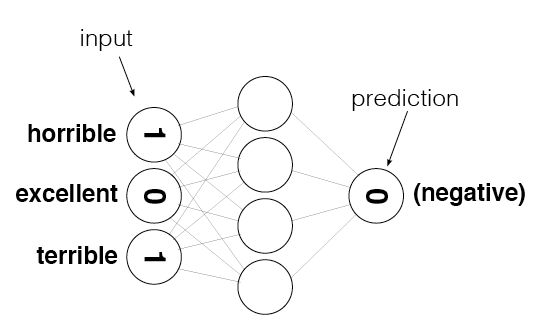

In [7]:
Image(filename='img/sentiment_network.png')

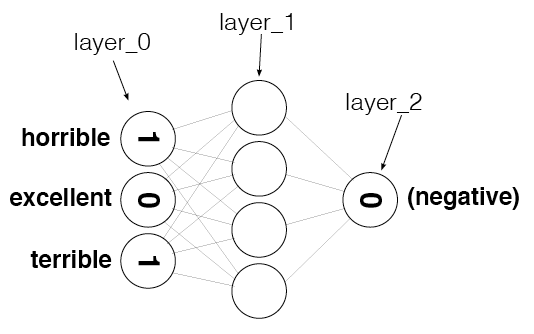

In [8]:
Image(filename='img/sentiment_network_2.png')

# Sentiment Network <a id='sentiment_network'></a>
- [Back to Bookmark](#bookmark)

In [9]:
import numpy as np
import time
import sys
from collections import Counter

In [10]:
# Encapsulate our neural network in a class
class SentimentNetwork:
    def __init__(self, reviews, labels, min_count = 10, polarity_cutoff = 0.1, \
                     hidden_nodes = 10, learning_rate = 0.1):
        """Create a SentimenNetwork with the given settings
        Args:
            reviews(list) - List of reviews used for training
            labels(list) - List of POSITIVE/NEGATIVE labels associated with the given reviews
            min_count(int) - Words should only be added to the vocabulary 
                             if they occur more than this many times
            polarity_cutoff(float) - The absolute value of a word's positive-to-negative
                                     ratio must be at least this big to be considered.
            hidden_nodes(int) - Number of nodes to create in the hidden layer
            learning_rate(float) - Learning rate to use while training
        
        """
        # Assign a seed to our random number generator to ensure we get
        # reproducable results during development 
        np.random.seed(1)

        # process the reviews and their associated labels so that everything
        # is ready for training
        self.pre_process_data(reviews, labels, polarity_cutoff, min_count)
        
        # Build the network to have the number of hidden nodes and the learning rate that
        # were passed into this initializer. Make the same number of input nodes as
        # there are vocabulary words and create a single output node.
        self.init_network(len(self.review_vocab), hidden_nodes, 1, learning_rate)

    def pre_process_data(self, reviews, labels, polarity_cutoff, min_count):
        
        # Calculate positive-to-negative ratios for words before building vocabulary
        positive_counts = Counter()
        negative_counts = Counter()
        total_counts = Counter()

        for i, review in enumerate(reviews):
            for word in review.split(" "):
                total_counts[word] += 1
                if labels[i] == 'POSITIVE':
                    positive_counts[word] += 1
                else:
                    negative_counts[word] += 1

        pos_neg_ratios = Counter()

        for word, count in list(total_counts.most_common()):
            if count >= 50:
                pos_neg_ratio = positive_counts[word] / float(negative_counts[word] + 1)
                pos_neg_ratios[word] = pos_neg_ratio

        for word, ratio in pos_neg_ratios.most_common():
            if ratio > 1:
                pos_neg_ratios[word] = np.log(ratio)
            else:
                pos_neg_ratios[word] = -np.log((1 / (ratio + 0.01)))

        # populate review_vocab with all of the words in the given reviews
        review_vocab = set()
        pos_neg_ratios_keys = pos_neg_ratios.keys()
        for review in reviews:
            for word in review.split(" "):
                # only add words that occur at least min_count times and for 
                # words with pos/neg ratios, only add words that meet the polarity_cutoff
                if total_counts[word] > min_count:
                    if word in pos_neg_ratios_keys:
                        if np.abs(pos_neg_ratios[word]) >= polarity_cutoff:
                            review_vocab.add(word)
                    else:
                        review_vocab.add(word)

        # Convert the vocabulary set to a list so we can access words via indices
        self.review_vocab = list(review_vocab)
        
        # populate label_vocab with all of the words in the given labels.
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        
        # Convert the label vocabulary set to a list so we can access labels via indices
        self.label_vocab = list(label_vocab)
        
        # Store the sizes of the review and label vocabularies.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Create a dictionary of words in the vocabulary mapped to index positions
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        # Create a dictionary of labels mapped to index positions
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i

    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Store the learning rate
        self.learning_rate = learning_rate

        # Initialize weights

        # These are the weights between the input layer and the hidden layer.
        self.weights_0_1 = np.zeros((self.input_nodes,self.hidden_nodes))

        # These are the weights between the hidden layer and the output layer.
        self.weights_1_2 = np.random.normal(scale = 1 / self.output_nodes ** 0.5, 
                                            size = (self.hidden_nodes, self.output_nodes))
        
        # The input layer, a two-dimensional matrix with shape 1 x hidden_nodes
        self.layer_1 = np.zeros((1,hidden_nodes))
    
    def get_target_for_label(self, label):
        return 1 if label == 'POSITIVE' else 0
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self, output):
        return output * (1 - output)
    
    def train(self, training_reviews_raw, training_labels):

        # pre-process training reviews so we can deal directly with \
        # the indices of non-zero inputs
        training_reviews = list()
        word2index_keys = self.word2index.keys()
        for review in training_reviews_raw:
            indices = set()
            for word in review.split(" "):
                if word in word2index_keys:
                    indices.add(self.word2index[word])
            training_reviews.append(list(indices))

        # make sure out we have a matching number of reviews and labels
        assert(len(training_reviews) == len(training_labels))
        
        # Keep track of correct predictions to display accuracy during training 
        correct_so_far = 0

        # Remember when we started for printing time statistics
        start = time.time()
        
        # loop through all the given reviews and run a forward and backward pass,
        # updating weights for every item
        for i in range(len(training_reviews)):
            
            # Get the next review and its correct label
            review = training_reviews[i]
            label = training_labels[i]
            
            ### Forward pass ###

            ## Hidden layer
            # Add in only the weights for non-zero items
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]

            ## Output layer
            layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))            
            
            ### Backward pass ###

            ## Output error
            layer_2_error = layer_2 - self.get_target_for_label(label) 
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)

            ## Backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T)
            # hidden layer gradients - no nonlinearity so it's the same as the error
            layer_1_delta = layer_1_error

            ## Update the weights
            self.weights_1_2 -= self.layer_1.T.dot(layer_2_delta) * self.learning_rate
            
            for index in review:
                self.weights_0_1[index] -= layer_1_delta[0] * self.learning_rate

            # Keep track of correct predictions.
            if(layer_2 >= 0.5 and label == 'POSITIVE'):
                correct_so_far += 1
            elif(layer_2 < 0.5 and label == 'NEGATIVE'):
                correct_so_far += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the training process. 
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Attempts to predict the labels for the given testing_reviews,
        and uses the test_labels to calculate the accuracy of those predictions.
        """
        
        # keep track of how many correct predictions we make
        correct = 0

        # we'll time how many predictions per second we make
        start = time.time()

        # Loop through each of the given reviews and call run to predict
        # its label. 
        for i, review in enumerate(testing_reviews):
            pred = self.run(review)
            if pred == testing_labels[i]:
                correct += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the prediction process. 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Returns a POSITIVE or NEGATIVE prediction for the given review.
        """
        # Run a forward pass through the network, like in the "train" function.
        
        # make sure reviews are all in lower case because our \
        # neural net is trained on lower case
        review = review.lower()
        
        ## Hidden layer
        self.layer_1 *= 0
        indices_of_words_used = set()
        word2index_keys = self.word2index.keys()
        
        for word in review.split(" "):
            if word in word2index_keys:
                indices_of_words_used.add(self.word2index[word])
                
        for index in indices_of_words_used:
            self.layer_1 += self.weights_0_1[index]
        
        ## Output layer
        layer_2 = self.sigmoid(self.layer_1.dot(self.weights_1_2))
         
        # Return POSITIVE for values above greater-than-or-equal-to 0.5 in the output layer;
        # return NEGATIVE for other values
        return "POSITIVE" if layer_2[0] >= 0.5 else "NEGATIVE"

# Performance <a id="performance"></a>
- [Back to Bookmark](#bookmark)

The following cell trains the network with a small polarity cutoff.

In [11]:
mlp = SentimentNetwork(reviews[:-1000], labels[:-1000], min_count=20, \
                       polarity_cutoff=0.05, learning_rate=0.01)
mlp.train(reviews[:-1000], labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):1786. #Correct:1994 #Trained:2501 Training Accuracy:79.7%
Progress:20.8% Speed(reviews/sec):1778. #Correct:4063 #Trained:5001 Training Accuracy:81.2%
Progress:31.2% Speed(reviews/sec):1847. #Correct:6176 #Trained:7501 Training Accuracy:82.3%
Progress:41.6% Speed(reviews/sec):1895. #Correct:8336 #Trained:10001 Training Accuracy:83.3%
Progress:52.0% Speed(reviews/sec):1905. #Correct:10501 #Trained:12501 Training Accuracy:84.0%
Progress:62.5% Speed(reviews/sec):1921. #Correct:12641 #Trained:15001 Training Accuracy:84.2%
Progress:72.9% Speed(reviews/sec):1890. #Correct:14782 #Trained:17501 Training Accuracy:84.4%
Progress:83.3% Speed(reviews/sec):1901. #Correct:16954 #Trained:20001 Training Accuracy:84.7%
Progress:93.7% Speed(reviews/sec):1887. #Correct:19143 #Trained:22501 Training Accuracy:85.0%
Progress:99.9% Speed(reviews/sec):1872. #Correct:20461 #Trained:24000 Training

The following cell tests its performance.

In [12]:
mlp.test(reviews[-1000:], labels[-1000:])

Progress:99.9% Speed(reviews/sec):1866. #Correct:859 #Tested:1000 Testing Accuracy:85.9%

The following cell trains the network with a much larger polarity cutoff.

In [13]:
mlp = SentimentNetwork(reviews[:-1000], labels[:-1000], min_count=20, \
                       polarity_cutoff=0.8, learning_rate=0.01)
mlp.train(reviews[:-1000], labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):6128. #Correct:2114 #Trained:2501 Training Accuracy:84.5%
Progress:20.8% Speed(reviews/sec):5813. #Correct:4235 #Trained:5001 Training Accuracy:84.6%
Progress:31.2% Speed(reviews/sec):5958. #Correct:6362 #Trained:7501 Training Accuracy:84.8%
Progress:41.6% Speed(reviews/sec):5999. #Correct:8513 #Trained:10001 Training Accuracy:85.1%
Progress:52.0% Speed(reviews/sec):5860. #Correct:10641 #Trained:12501 Training Accuracy:85.1%
Progress:62.5% Speed(reviews/sec):5168. #Correct:12796 #Trained:15001 Training Accuracy:85.3%
Progress:72.9% Speed(reviews/sec):5055. #Correct:14911 #Trained:17501 Training Accuracy:85.2%
Progress:83.3% Speed(reviews/sec):4735. #Correct:17077 #Trained:20001 Training Accuracy:85.3%
Progress:93.7% Speed(reviews/sec):4837. #Correct:19258 #Trained:22501 Training Accuracy:85.5%
Progress:99.9% Speed(reviews/sec):4900. #Correct:20552 #Trained:24000 Training

The following cell tests its performance.

In [14]:
mlp.test(reviews[-1000:], labels[-1000:])

Progress:99.9% Speed(reviews/sec):3756. #Correct:822 #Tested:1000 Testing Accuracy:82.2%

# Analysis of the Weights <a id='analysis'></a>
- [Back to Bookmark](#bookmark)

In [15]:
mlp_full = SentimentNetwork(reviews[:-1000], labels[:-1000], min_count=0, \
                            polarity_cutoff=0, learning_rate=0.01)

In [16]:
mlp_full.train(reviews[:-1000], labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):1686. #Correct:1962 #Trained:2501 Training Accuracy:78.4%
Progress:20.8% Speed(reviews/sec):1678. #Correct:4002 #Trained:5001 Training Accuracy:80.0%
Progress:31.2% Speed(reviews/sec):1632. #Correct:6120 #Trained:7501 Training Accuracy:81.5%
Progress:41.6% Speed(reviews/sec):1586. #Correct:8271 #Trained:10001 Training Accuracy:82.7%
Progress:52.0% Speed(reviews/sec):1582. #Correct:10431 #Trained:12501 Training Accuracy:83.4%
Progress:62.5% Speed(reviews/sec):1591. #Correct:12565 #Trained:15001 Training Accuracy:83.7%
Progress:72.9% Speed(reviews/sec):1602. #Correct:14670 #Trained:17501 Training Accuracy:83.8%
Progress:83.3% Speed(reviews/sec):1599. #Correct:16833 #Trained:20001 Training Accuracy:84.1%
Progress:93.7% Speed(reviews/sec):1584. #Correct:19015 #Trained:22501 Training Accuracy:84.5%
Progress:99.9% Speed(reviews/sec):1568. #Correct:20335 #Trained:24000 Training

In [17]:
def get_most_similar_words(focus = "horrible"):
    most_similar = Counter()

    for word in mlp_full.word2index.keys():
        most_similar[word] = np.dot(mlp_full.weights_0_1[mlp_full.word2index[word]],\
                                    mlp_full.weights_0_1[mlp_full.word2index[focus]])
    
    return most_similar.most_common()

In [18]:
get_most_similar_words("excellent")[:10]

[('excellent', 0.13672950757352476),
 ('perfect', 0.12548286087225946),
 ('amazing', 0.091827633925999741),
 ('today', 0.090223662694414203),
 ('wonderful', 0.089355976962214631),
 ('fun', 0.087504466674206888),
 ('great', 0.087141758882292072),
 ('best', 0.085810885617880583),
 ('liked', 0.077697629123843426),
 ('definitely', 0.076628781406966023)]

In [19]:
get_most_similar_words("terrible")[:10]

[('worst', 0.16966107259049851),
 ('awful', 0.12026847019691247),
 ('waste', 0.11945367265311006),
 ('poor', 0.092758887574435497),
 ('terrible', 0.09142538719772797),
 ('dull', 0.084209271678223618),
 ('poorly', 0.081241544516042055),
 ('disappointment', 0.08006475962136872),
 ('fails', 0.078599773723337527),
 ('disappointing', 0.07733948548032335)]

In [22]:
import matplotlib.colors as colors

positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

for i, review in enumerate(reviews):
    for word in review.split(" "):
        total_counts[word] += 1
        if labels[i] == 'POSITIVE':
            positive_counts[word] += 1
        else:
            negative_counts[word] += 1

pos_neg_ratios = Counter()

for word, count in list(total_counts.most_common()):
    if count >= 50:
        pos_neg_ratio = positive_counts[word] / float(negative_counts[word] + 1)
        pos_neg_ratios[word] = pos_neg_ratio

for word, ratio in pos_neg_ratios.most_common():
    if ratio > 1:
        pos_neg_ratios[word] = np.log(ratio)
    else:
        pos_neg_ratios[word] = -np.log((1 / (ratio + 0.01)))
        
words_to_visualize = list()
for word, ratio in pos_neg_ratios.most_common(500):
    if(word in mlp_full.word2index.keys()):
        words_to_visualize.append(word)
    
for word, ratio in list(reversed(pos_neg_ratios.most_common()))[0:500]:
    if(word in mlp_full.word2index.keys()):
        words_to_visualize.append(word)

In [23]:
pos = 0
neg = 0

colors_list = list()
vectors_list = list()
for word in words_to_visualize:
    if word in pos_neg_ratios.keys():
        vectors_list.append(mlp_full.weights_0_1[mlp_full.word2index[word]])
        if(pos_neg_ratios[word] > 0):
            pos+=1
            colors_list.append("#00ff00")
        else:
            neg+=1
            colors_list.append("#000000")

In [24]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(vectors_list)

In [26]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="vector T-SNE for most polarized words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=words_to_visualize))

p.scatter(x="x1", y="x2", size=8, source=source,color=colors_list)

word_labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(word_labels)

show(p)

# green indicates positive words, black indicates negative words

Loading BokehJS ...

/Users/Michael-Tu/anaconda3/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/Users/Michael-Tu/anaconda3/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
